In [52]:
import os.path # Directories, gotta have em.
import pickle # Better than .csv + a cute name.
from time import localtime, strftime # Time stamp everything.
import pandas as pd # DataFrames. Looping is easy. Obscure functions are fast.
import numpy as np # Do math on vectors with more obscure functions.
from tqdm.notebook import tqdm # Progress bars for sanity.
from IPython.display import display # Show me what's going on.
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import spacy # The engine. Big thanks to the geniuses at Explosion.
from spacy import displacy
from spacy.tokens import Doc, DocBin, Span
from spacy.matcher import DependencyMatcher
from spacy.util import filter_spans
nlp = spacy.load('en_core_web_trf')

In [29]:
from colextractor import corpus 
path = os.path.join(os.sep, 'home','jovyan','work')
targetcorpusname = os.path.join(path, 'corpora', 'ICNALE_processed.spacy')
ICNALE = corpus(targetcorpusname, reference = False)

Retrieving processed corpus from file 2021-12-03 10:08:57
Making corpus into a list 2021-12-03 10:08:57


In [30]:
# for result in ICNALE.search('job','a', max_matches=5):
#     print(result)

In [141]:
depbisname = os.path.join('vocab','ICNALEBigramStats.pickle')

if os.path.isfile(depbisname):
    print("You saved your work!", end=' ')
    print(strftime("%Y-%m-%d %H:%M:%S", localtime()))
    candidates = pd.read_pickle(depbisname)
    print("Good thinking!", end=' ')
    print(strftime("%Y-%m-%d %H:%M:%S", localtime()))
else:
    print("Run Candidate_Extraction or check the depbisname filename.", end=' ')
    print(strftime("%Y-%m-%d %H:%M:%S", localtime()))

You saved your work! 2021-12-03 12:34:39
Good thinking! 2021-12-03 12:34:40


(a) It is important for college students to have a part-time job. and (b) Smoking should be completely banned at all the restaurants in the country.

In [32]:
prompt_words = '|'.join(['student', 'important', 'college', 'part', 'time', 'part-time', 'job'])
word_pairs = [('student', 'college'),
              ('time', 'part'),
              ('job', 'part'),
              ('time', 'part'),
              ('job', 'time'),
              ('have', 'job')]

for hlem, dlem in word_pairs:
    candidates = candidates[~(candidates['hlem'].str.match(hlem) & candidates['dlem'].str.match(dlem))]

display(candidates)
candidates[candidates['hlem'].str.match('part')]

id         type        hlem htag        dlem  \
1       W_KOR_SMK0_179_B1_2.txt   NOUN + DET  restaurant   NN         the   
7       W_CHN_SMK0_026_A2_0.txt   NOUN + DET  restaurant  NNS         the   
10      W_THA_PTJ0_324_A2_0.txt   NOUN + DET         job   NN           a   
13      W_THA_PTJ0_341_A2_0.txt   NOUN + DET         job   NN           a   
22      W_HKG_PTJ0_013_B1_2.txt  NOUN + NOUN     student  NNS  university   
...                         ...          ...         ...  ...         ...   
716049  W_JPN_PTJ0_098_A2_0.txt    ADJ + ADV   important   JJ        most   
716050  W_JPN_PTJ0_098_A2_0.txt   NOUN + ADJ         man   NN         big   
716051  W_JPN_PTJ0_098_A2_0.txt   NOUN + ADJ       thing  NNS     various   
716052  W_JPN_PTJ0_098_A2_0.txt   NOUN + DET     college   NN     another   
716053  W_TWN_SMK0_200_B1_1.txt  VERB + VERB     suggest  VBP    prohibit   

       dtag  toks  
1        DT    18  
7        DT    14  
10       DT    14  
13       DT    13  
22       NN    13  
...     ...   ...  
716049  RBS     1  
716050   JJ     1  
716051   JJ     1  
716052   DT     1  
716053  VBN     1  

[703008 rows x 7 columns]

id         type  hlem htag       dlem dtag  toks
3633    W_CHN_PTJ0_098_B1_1.txt  NOUN + PREP  part   NN         of   IN     5
5515    W_PHL_PTJ0_039_B1_2.txt  NOUN + PREP  part   NN         of   IN     4
7221    W_TWN_PTJ0_090_B1_1.txt   NOUN + DET  part   NN        the   DT     4
11220   W_PAK_SMK0_105_B1_1.txt  NOUN + NOUN  part  NNS       body   NN     3
12498   W_JPN_SMK0_280_B1_2.txt  NOUN + PREP  part   NN         of   IN     3
...                         ...          ...   ...  ...        ...  ...   ...
712049  W_JPN_PTJ0_084_A2_0.txt   NOUN + DET  part   NN          a   DT     1
714124  W_JPN_PTJ0_114_A2_0.txt  NOUN + NOUN  part   NN       time   NN     1
714478  W_JPN_PTJ0_110_A2_0.txt   NOUN + ADJ  part   NN  different   JJ     1
714555  W_JPN_PTJ0_110_A2_0.txt  NOUN + PREP  part   NN         of   IN     1
715653  W_JPN_PTJ0_101_B1_1.txt  NOUN + NOUN  part   NN       time   NN     1

[1391 rows x 7 columns]

In [33]:
candidates['type'] = [(x+'_'+z) for (x, y, z) in candidates['type'].str.split(' ')]

In [34]:
types = [#'PREP_NOUN', 'NOUN_DET', 
    'VERB_VERB', 'VERB_AUX', 'VERB_PREP',
    'VERB_OBJ', 'NOUN_ADJ', 'VERB_ADV', 'VERB_PART', 'NOUN_PREP',
    'NOUN_NOUN', 'VERB_SUBJ', 'VERB_ADJ', 'ADJ_ADV']
candidates = candidates[candidates['type'].isin(types)]

# Get some Dependent Variables in There

In [35]:
essaystats = os.path.join('corpus_info', 'WE24.csv')

if os.path.isfile(essaystats):
    print("Yum, data!", end=' ')
    print(strftime("%Y-%m-%d %H:%M:%S", localtime()))
    studentinfo = pd.read_csv(essaystats)
    print(strftime("%Y-%m-%d %H:%M:%S", localtime()))
else:
    print("You will want to collect some information about these texts.")

Yum, data! 2021-12-03 10:09:06
2021-12-03 10:09:06


In [36]:
# display(studentinfo[studentinfo['VST'].isna()])
# display(studentinfo[['Code', 'VST', 'CEFR']])
# display(studentinfo)

## Now Let's try extracting some useful numbers

In [37]:
def reformatter(input_df):
    local_df = input_df.copy()
    local_df[['W', 'country', 'essay', 'id', 'CEFR']] = local_df['id'].str.split('_',expand=True,n=4)
    local_df['id'] = local_df[['W', 'country', 'id']].apply(lambda x: '_'.join(x), axis='columns')
    out_df = local_df.drop(['W', 'country', 'CEFR'], axis=1)
    out_df['filename'] = input_df['id']
    return out_df

def merger(student_info_df, candidate_df):
    # For written essays 2.4
    local_df = student_info_df[['Code', 'VST', 'CEFR']]
    # df = studentinfo[['Code', 'VST', 'CEFR', 'PTJ1 (wds)', 'SMK1 (wds)']]
    local_df = local_df.rename(columns={'Code': 'id'})
    out_df = candidate_df.merge(local_df, on='id', how='left')
    return out_df

def coll_to_string(input_df):
    cols = ["type", "hlem", "dlem"]
    local_df = input_df.copy()
    local_df['coll'] = local_df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    # x = with_colls[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    # y = x.apply(lambda row: ''.join(row.split(' ')))
    out_df = local_df.groupby(['id', 'VST', 'CEFR', 'essay', 'filename', 'coll']).agg('sum').reset_index()
    return out_df

# display(reformatter(candidates))
# display(merger(studentinfo, reformatter(candidates)))
stacked_colls = (coll_to_string(merger(studentinfo, reformatter(candidates))))
display(stacked_colls)

id   VST  CEFR essay                 filename  \
0       W_CHN_001  30.0  B1_1  PTJ0  W_CHN_PTJ0_001_B1_1.txt   
1       W_CHN_001  30.0  B1_1  PTJ0  W_CHN_PTJ0_001_B1_1.txt   
2       W_CHN_001  30.0  B1_1  PTJ0  W_CHN_PTJ0_001_B1_1.txt   
3       W_CHN_001  30.0  B1_1  PTJ0  W_CHN_PTJ0_001_B1_1.txt   
4       W_CHN_001  30.0  B1_1  PTJ0  W_CHN_PTJ0_001_B1_1.txt   
...           ...   ...   ...   ...                      ...   
484686  W_TWN_200  34.0  B1_1  SMK0  W_TWN_SMK0_200_B1_1.txt   
484687  W_TWN_200  34.0  B1_1  SMK0  W_TWN_SMK0_200_B1_1.txt   
484688  W_TWN_200  34.0  B1_1  SMK0  W_TWN_SMK0_200_B1_1.txt   
484689  W_TWN_200  34.0  B1_1  SMK0  W_TWN_SMK0_200_B1_1.txt   
484690  W_TWN_200  34.0  B1_1  SMK0  W_TWN_SMK0_200_B1_1.txt   

                                coll  toks  
0             ADJ_ADV_important_most     1  
1                ADJ_ADV_useful_very     1  
2                  NOUN_ADJ_chip_big     1  
3       NOUN_ADJ_experience_precious     1  
4         NOUN_ADJ_experience_social     1  
...                              ...   ...  
484686         VERB_VERB_bind_handle     1  
484687      VERB_VERB_pollute_affect     1  
484688     VERB_VERB_pollute_pollute     1  
484689       VERB_VERB_suggest_allow     1  
484690    VERB_VERB_suggest_prohibit     1  

[484691 rows x 7 columns]

Calculated separately for each essay type...

This was an attempt to manually calculate TF-IDF. For some reason, sparsePCA didn't work with these values, so I am going to use SKlearns TFIDF vectorizer.
*I figured this out. I needed to set the alpha value lower because the TFIDF values are less than 1. This is true of my handwritten TFIDF calculations as well as the SKlearn function


tf-idf(t, d) = tf(term_freq/doc_length) * log(num_docs/(doc_freq + 1))

In [187]:
hm = stacked_colls.coll.value_counts()
hm[hm>1]
# display(hm)
# hmm = hm.value_counts()
# display(hmm.index)
# sns.histplot(hmm, bins = 20)

VERB_PART_have_to               1721
VERB_AUX_ban_be                 1643
VERB_AUX_ban_should             1564
VERB_AUX_think_be               1517
VERB_SUBJ_have_student          1460
                                ... 
VERB_PREP_circulate_around         2
VERB_VERB_ask_tell                 2
VERB_SUBJ_find_undergraduate       2
VERB_OBJ_stop_kind                 2
VERB_OBJ_have_attraction           2
Name: coll, Length: 39422, dtype: int64

In [38]:
# num_docs = 2600
# term_freq = df.set_index(['id', 'essay', 'coll']).drop(['VST','CEFR'], axis=1).toks.reset_index(drop=True)
# doc_length = df.groupby(['id', 'essay'])['toks'].transform('sum')
# doc_freq = df.groupby(['coll', 'essay'])['id'].transform('count')

# df['tf_idf'] = term_freq / doc_length * np.log(num_docs/(doc_freq + 1))
# display(df)

In [39]:
bow_file = os.path.join('vocab', 'ICNALE_no_ptj_words.pkl')

if os.path.isfile(bow_file):
    print("Yum, data!", end=' ')
    print(strftime("%Y-%m-%d %H:%M:%S", localtime()))
    bow = pd.read_pickle(bow_file)
    print(strftime("%Y-%m-%d %H:%M:%S", localtime()))
else:
    print("Pivoting Table.")
#     df['toks'] = df['toks'].astype(bool)
    bow = pd.pivot_table(stacked_colls, index = ['id', 'VST', 'CEFR', 'essay', 'filename'], columns = ['coll'], values= ['toks'], fill_value=0) #this is pretty memory intensive. > 12GB available RAM required
#     bow = pd.pivot_table(stacked_colls, index = ['id', 'VST', 'CEFR', 'essay'], columns = ['coll'], values= ['tf_idf'], fill_value=0)
    bow.to_pickle(bow_file)

display(bow)

Yum, data! 2021-12-03 10:09:20
2021-12-03 10:09:23


toks  \
coll                                              ADJ_ADV_abhor_very   
id        VST  CEFR essay filename                                     
W_CHN_001 30.0 B1_1 PTJ0  W_CHN_PTJ0_001_B1_1.txt                  0   
                    SMK0  W_CHN_SMK0_001_B1_1.txt                  0   
W_CHN_002 27.0 B1_1 PTJ0  W_CHN_PTJ0_002_B1_1.txt                  0   
                    SMK0  W_CHN_SMK0_002_B1_1.txt                  0   
W_CHN_003 32.0 B1_1 PTJ0  W_CHN_PTJ0_003_B1_1.txt                  0   
...                                                              ...   
W_TWN_198 38.0 B1_2 SMK0  W_TWN_SMK0_198_B1_2.txt                  0   
W_TWN_199 36.0 B1_2 PTJ0  W_TWN_PTJ0_199_B1_2.txt                  0   
                    SMK0  W_TWN_SMK0_199_B1_2.txt                  0   
W_TWN_200 34.0 B1_1 PTJ0  W_TWN_PTJ0_200_B1_1.txt                  0   
                    SMK0  W_TWN_SMK0_200_B1_1.txt                  0   

                                                                     \
coll                                              ADJ_ADV_able_also   
id        VST  CEFR essay filename                                    
W_CHN_001 30.0 B1_1 PTJ0  W_CHN_PTJ0_001_B1_1.txt                 0   
                    SMK0  W_CHN_SMK0_001_B1_1.txt                 0   
W_CHN_002 27.0 B1_1 PTJ0  W_CHN_PTJ0_002_B1_1.txt                 0   
                    SMK0  W_CHN_SMK0_002_B1_1.txt                 0   
W_CHN_003 32.0 B1_1 PTJ0  W_CHN_PTJ0_003_B1_1.txt                 0   
...                                                             ...   
W_TWN_198 38.0 B1_2 SMK0  W_TWN_SMK0_198_B1_2.txt                 0   
W_TWN_199 36.0 B1_2 PTJ0  W_TWN_PTJ0_199_B1_2.txt                 0   
                    SMK0  W_TWN_SMK0_199_B1_2.txt                 0   
W_TWN_200 34.0 B1_1 PTJ0  W_TWN_PTJ0_200_B1_1.txt                 0   
                    SMK0  W_TWN_SMK0_200_B1_1.txt                 0   

                                                                      \
coll                                              ADJ_ADV_able_aptly   
id        VST  CEFR essay filename                                     
W_CHN_001 30.0 B1_1 PTJ0  W_CHN_PTJ0_001_B1_1.txt                  0   
                    SMK0  W_CHN_SMK0_001_B1_1.txt                  0   
W_CHN_002 27.0 B1_1 PTJ0  W_CHN_PTJ0_002_B1_1.txt                  0   
                    SMK0  W_CHN_SMK0_002_B1_1.txt                  0   
W_CHN_003 32.0 B1_1 PTJ0  W_CHN_PTJ0_003_B1_1.txt                  0   
...                                                              ...   
W_TWN_198 38.0 B1_2 SMK0  W_TWN_SMK0_198_B1_2.txt                  0   
W_TWN_199 36.0 B1_2 PTJ0  W_TWN_PTJ0_199_B1_2.txt                  0   
                    SMK0  W_TWN_SMK0_199_B1_2.txt                  0   
W_TWN_200 34.0 B1_1 PTJ0  W_TWN_PTJ0_200_B1_1.txt                  0   
                    SMK0  W_TWN_SMK0_200_B1_1.txt                  0   

                                                                    \
coll                                              ADJ_ADV_able_can   
id        VST  CEFR essay filename                                   
W_CHN_001 30.0 B1_1 PTJ0  W_CHN_PTJ0_001_B1_1.txt                0   
                    SMK0  W_CHN_SMK0_001_B1_1.txt                0   
W_CHN_002 27.0 B1_1 PTJ0  W_CHN_PTJ0_002_B1_1.txt                0   
                    SMK0  W_CHN_SMK0_002_B1_1.txt                0   
W_CHN_003 32.0 B1_1 PTJ0  W_CHN_PTJ0_003_B1_1.txt                0   
...                                                            ...   
W_TWN_198 38.0 B1_2 SMK0  W_TWN_SMK0_198_B1_2.txt                0   
W_TWN_199 36.0 B1_2 PTJ0  W_TWN_PTJ0_199_B1_2.txt                0   
                    SMK0  W_TWN_SMK0_199_B1_2.txt                0   
W_TWN_200 34.0 B1_1 PTJ0  W_TWN_PTJ0_200_B1_1.txt                0   
                    SMK0  W_TWN_SMK0_200_B1_1.txt                0   

                                                                      

In [134]:
plagiarizers = ['W_JPN_PTJ0_148_A2_0.txt',
 'W_KOR_PTJ0_038_A2_0.txt',
 'W_KOR_PTJ0_184_A2_0.txt',
 'W_KOR_PTJ0_122_A2_0.txt',
 'W_KOR_PTJ0_105_A2_0.txt',
 'W_KOR_PTJ0_169_A2_0.txt',
 'W_KOR_PTJ0_108_A2_0.txt',
 'W_KOR_PTJ0_028_A2_0.txt',
 'W_KOR_PTJ0_144_A2_0.txt',
 'W_JPN_PTJ0_267_B1_1.txt']

codes = []
for filename in plagiarizers:
    W, country, essay, num, CEFR, _ = filename.split('_')
    codes.append('_'.join((W, country, num)))
codes = '|'.join(codes)
newdf = studentinfo[(studentinfo['Code'].str.match(codes))]
display(newdf.iloc[:,1:10])

Country  PTJ1 (wds)  SMK1 (wds) Sex  Age  Grade/Degree Major/ Occupation  \
1047     JPN         236         195   M   19           2.0          Business   
1166     JPN         224         209   F   19           2.0       Agriculture   
1327     KOR         233         237   F   24           4.0          Business   
1337     KOR         261         255   M   22           3.0          Business   
1404     KOR         223         228   F   22           2.0          Business   
1407     KOR         264         253   F   22           3.0          Business   
1421     KOR         235         238   M   22           3.0          Business   
1443     KOR         232         236   F   25           3.0          Business   
1468     KOR         211         247   m   27           4.0          Business   
1483     KOR         266         255   M   25           3.0          Business   

                Acad. Genre   Test  
1047        Social Sciences  TOEIC  
1166  Sciences & Technology  TOEIC  
1327        Social Sciences    NaN  
1337        Social Sciences    NaN  
1404        Social Sciences    NaN  
1407        Social Sciences    NaN  
1421        Social Sciences    NaN  
1443        Social Sciences    NaN  
1468        Social Sciences    NaN  
1483        Social Sciences    NaN

In [40]:
# set(bow.index.get_level_values('CEFR')) #double checking there are no native speakers in the mix
ptj = bow.loc(axis=0)[pd.IndexSlice[:,:,:, 'PTJ0']]
smk = bow.loc(axis=0)[pd.IndexSlice[:,:,:, 'SMK0']]

df = ptj
df.shape

(2600, 116624)

In [41]:
# display(smk[smk.astype('bool') == True].count())

In [42]:
# Select only terms with a cumulative tf-idf of some value.
# smk = smk.loc[:,smk.sum(axis=0) > .1]
# smk.shape
# smk.loc[:,smk.count]

# Select only terms that appear in at least 26 documents.
# def reducer(input_df):
#     coll_counts = input_df[input_df.astype('bool') == True].count()
# #     display(coll_counts > 10)
#     colls_to_keep = coll_counts[coll_counts > 10].index
#     out_df = input_df.loc[:,colls_to_keep]
# #     out_df = input_df[colls_to_keep]
#     return out_df

# display(reducer(smk))
# display(np.count_nonzero(pre_x.values))

In [43]:
# sns.histplot(smk.index.get_level_values(1))
# sns.histplot(ptj.index.get_level_values(1))

# Calculate (51 - VST) then do a gamma regression. this reverses the distribution to give us a right tail, instead of a left tail. Gamma regression can handle a right tail.
# I would do this on PCs -- the result of PCA.
# Lasso regression is a more ML alternative.

In [44]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=True)
df_tfidf = transformer.fit_transform(df.values).toarray()
display(np.count_nonzero(df_tfidf))

219940

In [45]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold, RFECV
from scipy.sparse import csr_matrix
from sklearn.decomposition import SparsePCA
# from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

dispersion_minimum = 10

# One-hot encoded
# encoding_type = 'One-hot'
# sel = VarianceThreshold(threshold=dispersion_minimum/2600)
# X = sel.fit_transform(df)
# recovery_operation = sel.get_support(indices=True)
# X_index = df.iloc[:, recovery_operation]

# The tfidf approach
encoding_type = 'TFIDF'
X_cols = df.columns[np.count_nonzero(df_tfidf, axis=0) > dispersion_minimum]
X = df_tfidf[:,np.count_nonzero(df_tfidf, axis=0) > dispersion_minimum]
X_index = df.index

y = df.index.get_level_values(1)
num_features = X.shape[1]
print(f'The number of features is {num_features}')

# X, y = shuffle(X, y, random_state=0) # Apparently SKLearn chooses the some 5 folds every time by default
# This leads to the model fitting to a table organized by country
# making very, very, very bad predictions. Shuffling seems to help.

The number of features is 2990


0
count  2600.000000
mean     46.299231
std      10.777815
min      17.000000
25%      39.000000
50%      46.000000
75%      53.000000
max     102.000000

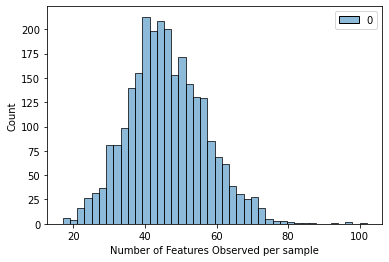

In [140]:
# display(pd.DataFrame(np.count_nonzero(df_tfidf, axis=1)).describe())
num_observations = pd.DataFrame(np.count_nonzero(X, axis=1))
# num_observations.describe()
ax1 = sns.histplot(num_observations)
ax1.set(xlabel='Number of Features Observed per sample')
num_observations.describe()

In [47]:
# For each number of components, save highest correlation with VST
pca_corrs = []
num_features = df.shape[1]
alpha = .01
    
def fit_pca(X, y, index, n_components, mode, alpha=1):
    transformer = SparsePCA(n_components=n_components, random_state=0, n_jobs=4, alpha=alpha)
    transformer.fit(X)
    transformed_data = transformer.transform(X)
    principle_components = pd.DataFrame(data=transformed_data, index=index, columns=None)
    target_predictors = principle_components.reset_index().drop(['CEFR','id','essay'], axis=1)
    
    if mode == 'tune':
        pca_X = target_predictors.drop('VST', axis=1)
        pca_y = target_predictors.VST
        # test the performance of the principal components num_scores times
        num_scores = 40
        scores = 0
        for i in range(num_scores):
            X_train, X_test, y_train, y_test = train_test_split(pca_X, pca_y, test_size=0.3)
            reg = LinearRegression().fit(X_train, y_train)
            y_prediction =  reg.predict(X_test)
            score = r2_score(y_test,y_prediction)
            scores += score
        avg_score = scores/num_scores
        return avg_score
    
    if mode == 'test':
        return transformer, transformed_data, principle_components, target_predictors
    

# with open('pca.txt', 'a') as f:
#     f.write('\n\n' + f'{num_features} Features, Encoded as {encoding_type}, alpha = {alpha}, minimum dispersion = {dispersion_minimum}\n' + strftime("%m-%d %H:%M", localtime()) + '\n')
    
# for i in range(4,13):
#     avg_score = fit_pca(X=X, y=y, index=X_index, n_components=i, mode='tune', alpha=alpha)
#     line = f'\n{i} components results in an average r squared of {avg_score}'
#     print(line)
#     with open('pca.txt', 'a') as f:
#         f.write(line)
#     pca_corrs.append((i, avg_score))

In [48]:
num_components=5
print(strftime("%m-%d %H:%M:%S", localtime()))
transformer, transformed_data, principle_components, target_predictors = fit_pca(X=X, y=y, index=df.index, n_components=num_components, mode='test', alpha=alpha)
print(strftime("%m-%d %H:%M:%S", localtime()))

12-03 10:10:08
12-03 10:11:06


In [53]:
def test_components(in_df, n_components):
    n_components = (target_predictors.shape[1]-1 if not n_components else n_components)
    pca_X = in_df.drop(['VST', 'filename'], axis=1).loc[:,:n_components]
    pca_y = in_df.VST
    # test the performance of the principal components num_scores times
    num_scores = 40
    scores = 0
    for i in range(num_scores):
        X_train, X_test, y_train, y_test = train_test_split(pca_X, pca_y, test_size=0.3)
        reg = LinearRegression().fit(X_train, y_train)
        y_prediction =  reg.predict(X_test)
        score = r2_score(y_test,y_prediction)
        scores += score
    avg_score = scores/num_scores
    return avg_score

for i in range(num_components-1):
    r_2 = test_components(target_predictors, i+1)
    print(f'{i+1} components makes an r^2 of {r_2}')

1 components makes an r^2 of 0.11942614490673224
2 components makes an r^2 of 0.11971017693312233
3 components makes an r^2 of 0.13484188158651397
4 components makes an r^2 of 0.14678112197055554


It would be nice to make spaCy highlight the bigrams that contribute to a principal component score.

In order to achieve that, I would want to save the token indices... or I could just search the text for the lemmas that I already have. For that, I would want to extract "hlem" "dlem" and possibly "coltype".

As for highlighting

In [54]:
pc = pd.DataFrame(data=transformer.components_, index=range(num_components), columns=X_cols)

# list_of_tups = []
# for comp in range(num_components):
#     for row in range(10):
#         coll = pc.loc[comp].sort_values(ascending=False)[:15].index[row][1]
#         weight = pc.loc[comp].sort_values(ascending=False)[:15][row]
#         list_of_tups.append((comp, coll, weight))
        
# for_word = pd.DataFrame(list_of_tups, columns=['Principal Component','Collocation', 'Weight'])
# display(round(for_word, 2))

# for i in range(num_components):
#     display(pc.loc[i].sort_values(ascending=False)[:8])

Kris's code for creating an HTML of concordance lines
I want to use display(HTML(output)) to render the HTML in Jupyter :)


    def dep_conc(example_list,filename = "results",hits = 50, seed = None):
	random.seed(seed) #set seed
	if len(example_list) <= hits: #if the desired number of hits is more than the size of the hit list
		sample_list = example_list #just use the hit list
	else:
		sample_list = random.sample(example_list,hits) #otherwise, produce a random sample
	
	### This section builds the header material for the .html file.
	outstring = "<!doctype html>\n" ##declare formatting
	root = ET.Element("html") #create root tag
	head = ET.SubElement(root,"head") #create header
	style = ET.SubElement(head,"style") #add style tag
	style.text = "dep {color:red;} \n dep_head {color:blue;}" #set styles for dep and dep_head tags
	
	#iterate through sentences
	for sentence in sample_list:
		paragraph = ET.SubElement(root,"p") #create new paragraph 
		for token in sentence: #iterate through tokens
			if "_dep" in token: #if it is a dependent
				dep = ET.SubElement(paragraph,"dep") #use the dep tag, making it red
				dep.text = token + " " #add the text
			elif "_head" in token: #if it is a head
				dep_head = ET.SubElement(paragraph,"dep_head") #use the dep_head tag, making it blue
				dep_head.text = token + " " #add the text
			else:
				word = ET.SubElement(paragraph,"word") #otherwise, use the word tag (no special formatting)
				word.text = token + " " #add the text
	
	out_name = filename + ".html" #create filename
	outstring = outstring + ET.tostring(root,method = "html").decode("utf-8") #create output string in correct encoding
	outf = open(out_name, "w") #create file
	outf.write(outstring) #write file
	outf.flush()
	outf.close()

In [61]:
color_codes = ['#8f4e18', '#9d632c', '#aa7841', '#b78d57', '#c5a26f', '#d2b787', '#e1cca1', '#efe1bc', '#fff6d7']
colors = {}
for i, code in enumerate(color_codes):
    colors[str(i)] = code
print(colors)

{'0': '#8f4e18', '1': '#9d632c', '2': '#aa7841', '3': '#b78d57', '4': '#c5a26f', '5': '#d2b787', '6': '#e1cca1', '7': '#efe1bc', '8': '#fff6d7'}


In [298]:
print(inds)
for i, doc in enumerate(ICNALE.docs):
    if doc._.name in inds:
        print(i, doc._.name)
        display(principle_components.xs(doc._.name, level='filename'))

['W_THA_PTJ0_230_A2_0.txt', 'W_KOR_PTJ0_009_B1_1.txt', 'W_THA_PTJ0_042_A2_0.txt', 'W_THA_PTJ0_250_B1_1.txt', 'W_JPN_PTJ0_226_A2_0.txt', 'W_JPN_PTJ0_196_B1_1.txt', 'W_CHN_PTJ0_399_B1_1.txt', 'W_KOR_PTJ0_293_B1_2.txt', 'W_IDN_PTJ0_074_B1_1.txt', 'W_IDN_PTJ0_051_B1_1.txt']
405 W_KOR_PTJ0_293_B1_2.txt


0         1         2         3         4
id        VST  CEFR essay                                                  
W_KOR_293 42.0 B1_2 PTJ0  -0.024294 -0.049014 -0.009847  0.006917  0.246822

1457 W_JPN_PTJ0_226_A2_0.txt


0         1         2         3         4
id        VST  CEFR essay                                                  
W_JPN_226 22.0 A2_0 PTJ0   0.127205 -0.025831 -0.031424 -0.000515  0.257751

2365 W_KOR_PTJ0_009_B1_1.txt


0         1         2         3         4
id        VST  CEFR essay                                                 
W_KOR_009 44.0 B1_1 PTJ0   0.02059 -0.014657  0.037964 -0.004381  0.276733

2630 W_THA_PTJ0_250_B1_1.txt


0         1         2         3         4
id        VST  CEFR essay                                                  
W_THA_250 29.0 B1_1 PTJ0   0.042626 -0.011811 -0.005357 -0.029812  0.258255

3963 W_CHN_PTJ0_399_B1_1.txt


0         1        2         3         4
id        VST  CEFR essay                                                 
W_CHN_399 25.0 B1_1 PTJ0   0.014755 -0.023163 -0.01147  0.011968  0.247482

4231 W_THA_PTJ0_042_A2_0.txt


0         1         2         3         4
id        VST  CEFR essay                                                  
W_THA_042 21.0 A2_0 PTJ0   0.003409  0.061795  0.003545  0.033821  0.258831

4244 W_THA_PTJ0_230_A2_0.txt


0         1         2         3         4
id        VST  CEFR essay                                                  
W_THA_230 24.0 A2_0 PTJ0  -0.027306  0.013505  0.022412  0.041324  0.362592

4425 W_IDN_PTJ0_074_B1_1.txt


0         1         2         3         4
id        VST  CEFR essay                                                  
W_IDN_074 32.0 B1_1 PTJ0  -0.024123  0.017402 -0.005792 -0.030184  0.237366

4550 W_IDN_PTJ0_051_B1_1.txt


0         1         2         3         4
id        VST  CEFR essay                                                  
W_IDN_051 32.0 B1_1 PTJ0  -0.023073 -0.006682 -0.035603  0.036247  0.236224

5257 W_JPN_PTJ0_196_B1_1.txt


0         1         2         3        4
id        VST  CEFR essay                                                 
W_JPN_196 27.0 B1_1 PTJ0   0.041168 -0.035211 -0.027017 -0.020685  0.25698

In [266]:
xx = principle_components[1].nlargest(n=10)
principle_components.xs('W_PHL_SMK0_161_A2_0.txt', level='filename')
my_list = []
for i in xx:
    my_list.append()
    

id         VST   CEFR  essay  filename               
W_THA_183  23.0  A2_0  PTJ0   W_THA_PTJ0_183_A2_0.txt    0.309222
W_THA_336  24.0  A2_0  PTJ0   W_THA_PTJ0_336_A2_0.txt    0.276626
W_THA_021  25.0  B1_1  PTJ0   W_THA_PTJ0_021_B1_1.txt    0.263521
W_JPN_400  20.0  A2_0  PTJ0   W_JPN_PTJ0_400_A2_0.txt    0.263153
W_THA_391  35.0  B1_1  PTJ0   W_THA_PTJ0_391_B1_1.txt    0.238427
W_THA_106  20.0  A2_0  PTJ0   W_THA_PTJ0_106_A2_0.txt    0.231554
W_THA_159  29.0  B1_1  PTJ0   W_THA_PTJ0_159_B1_1.txt    0.222718
W_THA_258  21.0  A2_0  PTJ0   W_THA_PTJ0_258_A2_0.txt    0.219341
W_THA_346  34.0  B1_1  PTJ0   W_THA_PTJ0_346_B1_1.txt    0.198762
W_IDN_040  36.0  B1_2  PTJ0   W_IDN_PTJ0_040_B1_2.txt    0.197888
Name: 1, dtype: float64

In [348]:
from wasabi import Printer, row
match = Printer()
matcher = DependencyMatcher(nlp.vocab)

def get_exemplars(data, pc_num, num_exemplars=10):
    inds = []
    ind = np.argpartition(data[pc_num], -num_exemplars)[-num_exemplars:]
    ind = ind[np.argsort(data[pc_num][ind])]
    for i in reversed(ind):
        inds.append(principle_components.iloc[i].name[4])
    exemplars = []
    for doc in ICNALE.docs:
        for i in inds:
            if doc._.name.startswith(i):
                exemplars.append(doc)
    return(exemplars)
    # display([t._.name for t in exemplars])

def pattern_extractor(label, hlem, dlem):
    pattern = [
        {
            "RIGHT_ID": (label + ' head'),
            "RIGHT_ATTRS": {"LEMMA": hlem, "IS_ALPHA": True}
        },
        {
            "LEFT_ID": (label + ' head'),
            "REL_OP": ">",
            "RIGHT_ID": (label + ' dependent'),
            "RIGHT_ATTRS": {"LEMMA": dlem, "IS_ALPHA": True}
        }]
    matcher.add(label, [pattern]) 
    
def centered_concordancer(texts, pad_left = 5, pad_right = 5):
    for idoc, doc in enumerate(texts):
        my_spans = []
        matches = matcher(doc)
        for i, (match_id, (ihead, idep)) in enumerate(matches, start=1):
            start, end = sorted([ihead, idep])
            sent = doc[start].sent
            left_sent_edge = sent[0].i
            right_sent_edge = sent[-1].i
            text = ' '.join((
                doc[max(start - pad_left, left_sent_edge): start].text,
                match.text(doc[start], color="red", no_print=True),
                doc[start + 1: end].text,
                match.text(doc[end], color="red", no_print=True),
                doc[end+1: min(end+pad_right, right_sent_edge)+1].text))
            print(row(
                (i, nlp.vocab.strings[match_id], text),
                widths = [3, 20, 120],
                aligns=['l','l','c']))
            
exemplars = get_exemplars(data=principle_components, pc_num=1, num_exemplars=10)

for label in pc.loc[pc_num].sort_values(ascending=False)[:12].index.get_level_values(1):
    pos_1, pos_2, hlem, dlem = label.split('_')
    pattern_extractor(label, hlem, dlem)
    
# display(pc.loc[pc_num].sort_values(ascending=False)[:12].reset_index())

centered_concordancer(exemplars)

1     VERB_OBJ_get_money                                   may want to work and get  money .                               
1     VERB_PART_get_to                          about money, they want to  get more income so part time                    
2     VERB_PREP_get_by                            good experience and we will get income by ourselves.                     
3     VERB_VERB_want_get                     problem about money, they want to get more income so part time                
4     VERB_AUX_get_will                         a good experience and we will  get income by ourselves.                    
1     VERB_PART_get_to                                Many students want to  get part-time job for                         
2     VERB_PREP_get_for                            Many students want to get part-time job for money.                      
3     VERB_VERB_want_get                              Many students want to get part-time job for                          
1     VE

In [ ]:
# for idoc, doc in enumerate(exemplars):
#     my_spans = []
#     matches = matcher(doc)
#     for i, (match_id, (ihead, idep)) in enumerate(matches, start=1):
#         start, end = sorted([ihead, idep])
#         pre = doc[max(start - 7, 0): start]
#         target = match.text(doc[start: end + 1], color="red", no_print=True)
#         post = doc[end+1: end+8]
#         print(row(
#             (i, nlp.vocab.strings[match_id], pre, target, post),
#             widths = [3, 20, 40, 60, 40],
#             aligns=['l','l','r','c','l']))

In [252]:
pc_num = 4

a = principle_components[pc_num]
inds = []
# ind = np.argpartition(a, 5)[:5]
ind = np.argpartition(a, -10)[-10:]
ind = ind[np.argsort(a[ind])]
for i in reversed(ind):
    inds.append(principle_components.iloc[i].name[4])
# print(inds)
exemplars = []
for doc in ICNALE.docs:
    for i in inds:
        if doc._.name.startswith(i):
            exemplars.append(doc)
display([t._.name for t in exemplars])
            
matcher = DependencyMatcher(nlp.vocab)

def pattern_extractor(i, hlem, dlem):
    pattern = [
        {
            "RIGHT_ID": (str(i) + ' head'),
            "RIGHT_ATTRS": {"LEMMA": hlem, "IS_ALPHA": True}
        },
        {
            "LEFT_ID": (str(i) + ' head'),
            "REL_OP": ">",
            "RIGHT_ID": (str(i) + ' dependent'),
            "RIGHT_ATTRS": {"LEMMA": dlem, "IS_ALPHA": True}
        }]
    matcher.add(str(i), [pattern]) 

for i, label in enumerate(pc.loc[pc_num].sort_values(ascending=False)[:12].index.get_level_values(1)):
    pos_1, pos_2, hlem, dlem = label.split('_')
    pattern_extractor(i, hlem, dlem)  

for doc in exemplars:
    my_spans = []
    matches = matcher(doc)
    for match_id, (ihead, idep) in matches:
        start, end = sorted([ihead, idep])
        if end - start <= 3:
            span = Span(doc, start, end+1, label=match_id)
        my_spans.append(span)
        doc.ents = filter_spans(my_spans)  # add span to doc.ents
#     display([(ent.text, ent.label_) for ent in doc.ents])

display(pc.loc[pc_num].sort_values(ascending=False)[:12].reset_index())
for doc in exemplars:
    displacy.render(doc, style='ent', options = {"colors":colors})
    print()

['W_KOR_PTJ0_293_B1_2.txt',
 'W_JPN_PTJ0_226_A2_0.txt',
 'W_KOR_PTJ0_009_B1_1.txt',
 'W_THA_PTJ0_250_B1_1.txt',
 'W_CHN_PTJ0_399_B1_1.txt',
 'W_THA_PTJ0_042_A2_0.txt',
 'W_THA_PTJ0_230_A2_0.txt',
 'W_IDN_PTJ0_074_B1_1.txt',
 'W_IDN_PTJ0_051_B1_1.txt',
 'W_JPN_PTJ0_196_B1_1.txt']

level_0                     coll         4
0     toks       VERB_OBJ_get_money  0.446528
1     toks         VERB_PART_get_to  0.445923
2     toks         VERB_AUX_get_can  0.356519
3     toks  VERB_OBJ_get_experience  0.277279
4     toks       VERB_PREP_get_from  0.186136
5     toks         VERB_PREP_get_in  0.167585
6     toks        VERB_PREP_get_for  0.164773
7     toks         VERB_PREP_get_by  0.124473
8     toks       VERB_VERB_want_get  0.120147
9     toks        VERB_AUX_get_will  0.108864
10    toks        VERB_VERB_get_get  0.091508
11    toks        VERB_PART_get_not  0.083021

In [188]:
matcher = DependencyMatcher(nlp.vocab)
pattern_extractor('test', 'have', 'for')
matches = []
for i, doc in enumerate(ICNALE.docs):
    match = matcher(doc)
    if match:
        matches.append((i, match))
    if len(matches) > 1:
        break
        
for i, match in matches:
    print(match)
    doc = ICNALE.docs[i]
    for match_id, (ihead, idep) in match:
        start, end = sorted([ihead, idep])
        span = Span(doc, start, end+1, label=match_id)
        doc.ents = [span]
        displacy.render(doc, style='ent', options = {"colors":colors})

[(1618900948208871284, [8, 4])]


[(1618900948208871284, [60, 56])]


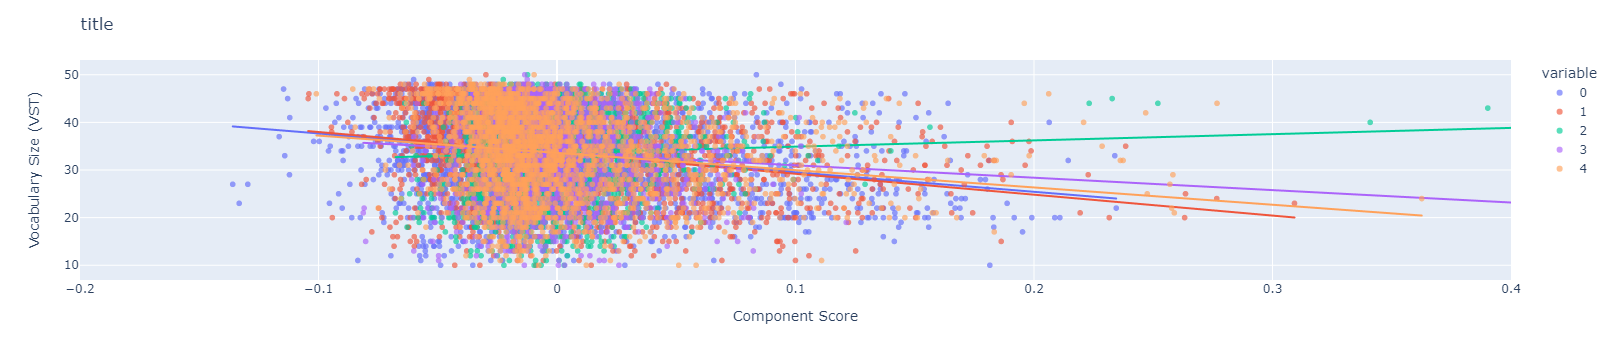

In [137]:
# value_vars = principle_components.reset_index().columns.drop(['CEFR','essay','id'])
# display(value_vars)
# display(melted_predictors)
melted_predictors = pd.melt(principle_components.reset_index(), id_vars=['id','VST'], value_vars=principle_components.columns)

fig = px.scatter(melted_predictors,
                 x='value',
                 y='VST',
                 color='variable',
                 opacity=0.65,
                 trendline='ols',
                 # labels=labels
                )

fig.update_xaxes(range=[-.2, .4])

fig.update_layout(
    xaxis_title='Component Score',
    yaxis_title="Vocabulary Size (VST)",
    title="title"
)
fig.show()

In [138]:
kitchen_sink = studentinfo.merge(principle_components, left_on='Code', right_on='id')
kitchen_sink.iloc[:,:-8]

# corr = kitchen_sink.corr()
# sns.set(rc={'figure.figsize':(30,20)})
# sns.heatmap(corr, annot=False) 

Code Country  PTJ1 (wds)  SMK1 (wds) Sex  Age  Grade/Degree  \
0     W_CHN_001     CHN         271         219   F   20           2.0   
1     W_CHN_002     CHN         203         292   F   21           3.0   
2     W_CHN_003     CHN         238         250   F   20           3.0   
3     W_CHN_004     CHN         269         230   F   20           2.0   
4     W_CHN_005     CHN         225         208   M   20           2.0   
...         ...     ...         ...         ...  ..  ...           ...   
2595  W_TWN_196     TWN         210         211   M   20           2.0   
2596  W_TWN_197     TWN         233         199   F   20           4.0   
2597  W_TWN_198     TWN         217         213   F   18           1.0   
2598  W_TWN_199     TWN         213         305   F   18           1.0   
2599  W_TWN_200     TWN         255         256   F   22           4.0   

         Major/ Occupation            Acad. Genre Test  ... Primary  \
0                      Law        Social Sciences  CEE  ...     2.0   
1                      Law        Social Sciences  CEE  ...     2.5   
2                      Law        Social Sciences  CEE  ...     3.5   
3                Chemistry  Sciences & Technology  CEE  ...     1.0   
4                Chemistry  Sciences & Technology  CEE  ...     2.0   
...                    ...                    ...  ...  ...     ...   
2595               Science  Sciences & Technology  NaN  ...     2.0   
2596  Chemical Engineering  Sciences & Technology  NaN  ...     2.5   
2597              Business        Social Sciences  NaN  ...     3.5   
2598    European Languages             Humanities  NaN  ...     3.0   
2599      Material Science  Sciences & Technology  NaN  ...     3.0   

      Secondary College  Inschool  Outschool  Listening  Reading  Speaking  \
0          3.63    4.25      3.89       3.56       4.00     4.50      3.50   
1          4.00    1.86      3.00       2.88       3.00     3.00      2.75   
2          4.25    4.25      4.22       4.11       5.00     4.00      3.75   
3          2.75    4.25      3.44       3.00       3.75     3.75      3.25   
4          3.63    4.88      4.33       3.67       5.00     5.00      3.25   
...         ...     ...       ...        ...        ...      ...       ...   
2595       3.88    3.75      3.67       3.56       4.25     4.75      2.00   
2596       4.00    2.75      3.44       3.11       4.00     4.00      2.25   
2597       4.00    4.88      5.00       3.67       5.00     5.00      3.50   
2598       3.25    3.88      3.56       3.44       3.75     4.25      3.25   
2599       3.25    3.50      3.67       3.00       3.25     3.50      3.75   

      Writing  NS  
0        3.75   4  
1        3.33   3  
2        4.25   4  
3        3.25   3  
4        3.75   3  
...       ...  ..  
2595     4.25   5  
2596     3.25   2  
2597     4.25   5  
2598     3.00   5  
2599     3.00   3  

[2600 rows x 27 columns]

In [139]:
target_predictors.to_csv('VST_ptj_5_pcs.csv', index=False)
# kitchen_sink.to_csv('kitchen_sink_8_pcs.csv', index=False)